# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')

In [2]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(kt['ABBREVIATION'].values, kt['KEGG ID(S)'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD2.xlsx', sheet_name = 'reactions')
#allRxnDf[:5]

In [5]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
fluxSet = ['ppi-pfk','atp-pfk','test']
for f in range(len(fluxSet)):
    selectedRxnDf[f] = allRxnDf.loc[allRxnDf[fluxSet[f]] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet[f]]]
    selectedRxnDf[f].rename(columns = {fluxSet[f]:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf                                                        # processing


In [6]:
selectedRxnDf[2]

,Name,AbbreviationFormula,KeggFormula,flux
0,ATPM,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,1
1,CBP,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,1
3,GLK-GTP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,1
5,PGMT,g1p <=> g6p,C00103 <=> C00092,1
6,PGI,g6p <=> f6p,C00092 <=> C00085,2
7,PFK-PPi,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,2
8,PFK-ATP,atp + f6p <=> adp + fdp,C00002 + C00085 <=> C00008 + C00354,2
9,FBA,fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,2
10,TPI,dhap <=> g3p,C00111 <=> C00118,2
11,GAPDH,pi + nad + g3p <=> nadh + 13dpg,C00009 + C00003 + C00118 <=> C00004 + C00236,4


In [7]:
ratio = [1]
exp_data_file = "ctherm_exp_data.txt"
exp_data = []
all_data = {}
f = open(exp_data_file, "r")
l = f.readline()
l = f.readline()
mets_constr = [i for i in l.strip("\n").split(" ") if i != ""]
l = f.readline()
while l != "":
    data = [float(i) for i in l.strip("\n").split(" ") if i != ""]
    exp_data.append(dict(zip(mets_constr, data)))
    l = f.readline()

f.close()
Uf = 2 #Uncertainity factor 
ref_conc0 = {'C00469': 10,   #ethanol
            'C00004': 0.08,  #NADH
            'C00024': 0.83,  #Acetyl-CoA
            'C00002': 2.70,  #ATP
            'C00008': 0.11,  #ADP
            'C00020': 0.22,  #AMP
            'C00354': 1.50,  #FBP
            'C00092': 8.19,  #G6P
            'C00074': 0.69,  #Phosphoenolpyruvate
            'C00005': 0.38,  #NADPH
            'C00022': 12.65, #Pyruvate
            'C00103': 6.66,  #G1P
            'C00044': 0.28,  #GTP
            'C00035': 0.01   #GDP
            }

In [8]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf


# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
# loop over different models

for f in range(len(fluxSet)):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data[f] = {}
    ref_conc = {k: float(v) / 1000 for k,v in ref_conc0.items()}
    for cpd, conc in ref_conc.items():
        pp.bounds.SetBounds(cpd, conc / Uf,conc * Uf )
    for r in ratio:
        dictCur ={}
        all_data[f][r] ={}
        # fix PPI/PI ratio
        pp.bounds.SetBounds('C00013', 1e-3 * 8,1e-3 * 8 ) #set PPi conc
        pp.bounds.SetBounds('C00009', 1e-3 * 10,1e-3 * 10 ) # set Pi conc
        t = 0

        for d in exp_data:
            for cpd, conc in ref_conc.items():
                if cpd == "C00469":
                    # absolute EtOH conc
                    pp.bounds.SetBounds(cpd,d[cpd], d[cpd])
                elif cpd == "C00004":
                    # NADH/NAD+ ratio
                    pp.bounds.SetBounds(cpd, 1/Uf * conc * float(d[cpd]) / 0.3, Uf * conc * float(d[cpd]) / 0.3)
                elif cpd == "C00044":
                    # NADH/NAD+ ratio
                    pp.bounds.SetBounds(cpd,1/Uf * conc * float(d['C00002']), Uf * conc * float(d['C00002']))
                #elif cpd == "C00008" and t == 0:
                    #p['bounds'][cpd] = (conc, ) * 2
                elif cpd not in ["C00008","C00085","C00006","C00003","C00118","C00011","C00197","C00010","C00035"]:
                    # other relative data
                    pp.bounds.SetBounds(cpd,1/Uf * conc * d[cpd], Uf * conc * d[cpd])

            
            # calculate the min-max driving force
            mdf_data = pp.calc_mdf()
            #mdf_data.mdf_plot
            # store the data
            dictCur[t] = {'mdf': mdf_data.mdf}
            dictCur[t]["reaction prices"] = {r.reaction.reaction_id: float(r.shadow_price) for r in mdf_data.reaction_data}
            dictCur[t]["gibbs energies"] = {r.reaction.reaction_id: float(r.dGr) for r in mdf_data.reaction_data}
            dictCur[t]["concentrations"] = {str(c.compound): float(c.concentration) for c in mdf_data.compound_data}
            dictCur[t]["compound prices"] = {str(c.compound): float(c.shadow_price) for c in mdf_data.compound_data}
            dictCur[t]["compound lower"] = {str(c.compound): float(mdf_data.model.concentration_bounds.GetLowerBound(str(c.compound))) for c in mdf_data.compound_data}
            dictCur[t]["compound upper"] = {str(c.compound): float(mdf_data.model.concentration_bounds.GetUpperBound(str(c.compound))) for c in mdf_data.compound_data}

            all_data[f][r] = dictCur
            t += 1
    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
mdf_data={}

fng_data={}
for k in range(3):
    fng_data[k]={}
    for r in [1]:
        fng_data[k][r]={}
        for t in range(10):
            fng_data[k][r][t] = all_data[k][r][t]["mdf"]

z={}
for k in range(3):
    z[k]={}
    for t in range(10):
        z[k][t] = float(fng_data[k][1][t]) 

df = pd.DataFrame.from_dict(z)
plt.plot(df)
plt.legend(['PPI_PFK','ATP_PFK','ATP_PFK+GAPN+WT'])
plt.xlabel('time points')
plt.ylabel('MDF')
plt.title('MDF vs timepoints')

In [ ]:
fng_data={}
for r in [1]:
    fng_data[r]={}
    for t in range(10):
        fng_data[r][t] = all_data[1][r][t]["reaction prices"]["PFK-ATP"]
z={}
for t in range(10):
    z[t] = float(fng_data[1][t]) 
plt.plot(*zip(*sorted(z.items())))
plt.xlabel('time points')
plt.ylabel('sensitivity of ATP-PFK')
plt.title('sensitivity of ATP-PFK vs timepoints')

In [ ]:
#for the case of PPI-PFK
for r in [1]:
    mdf_data[r]={}
    for t in range(10):
        mdf_data[r][t] = all_data[1][r][t]["mdf"]
y={}
for t in range(10):
    y[t] = float(mdf_data[1][t]) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('time points')
plt.ylabel('MDF')
plt.title('MDF vs timepoints')

Text(0.5, 1.0, 'sensitivity of PFK vs timepoints')

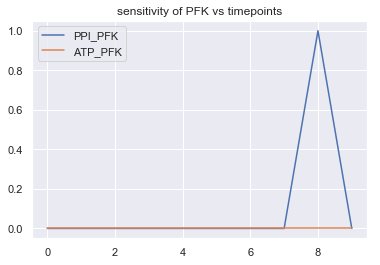

In [17]:
fng_data={}
for k in range(2):
    fng_data[k]={}
    for r in [1]:
        fng_data[k][r]={}
        for t in range(10):
            if k > 0:
                fng_data[k][r][t] = all_data[k][r][t]["reaction prices"]["PFK-ATP"]
            else:
                fng_data[k][r][t] = all_data[k][r][t]["reaction prices"]["PFK-PPi"]
z={}
for k in range(2):
    z[k]={}
    for t in range(10):
        z[k][t] = float(fng_data[k][1][t]) 

df = pd.DataFrame.from_dict(z)
plt.plot(df)
plt.legend(['PPI_PFK','ATP_PFK'])
plt.title('sensitivity of PFK vs timepoints')

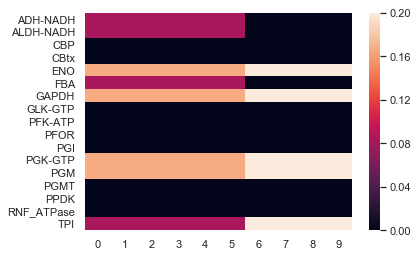

In [18]:
fng_data={}
for t in range(10):
    fng_data[t] = all_data[1][1][t]["reaction prices"] # the first index 0: PFK-PPI, 1: PFK-ATP
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

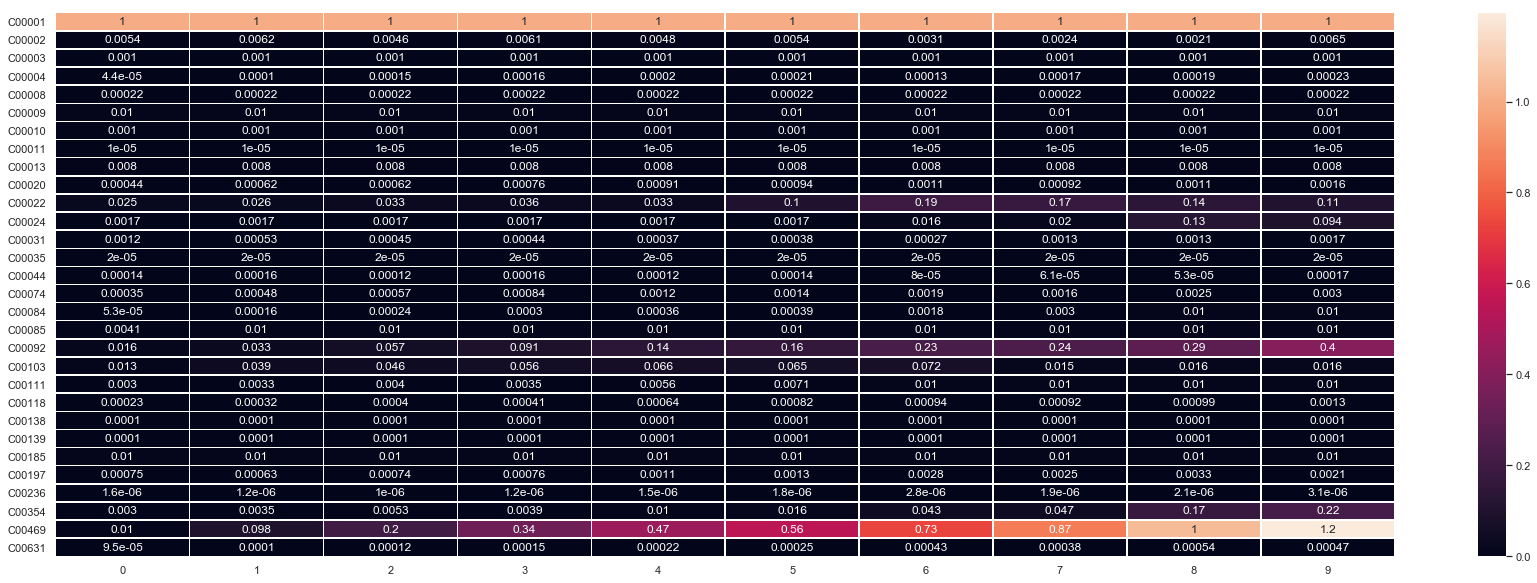

In [19]:
fng_data={}
for t in range(10):
    fng_data[t] = all_data[1][1][t]["concentrations"]
df = pd.DataFrame.from_dict(fng_data)
f, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(df,annot= True, linewidths=.5, ax=ax)

In [24]:
fng_data={}
fng_data2={}
for t in range(10):
    fng_data[t] = all_data[0][1][t]["compound lower"]
    fng_data2[t] = all_data[0][1][t]["compound upper"]    
dfl = pd.DataFrame.from_dict(fng_data)
dfu = pd.DataFrame.from_dict(fng_data2)

dfl[9],dfu[9]

(C00001    1.000000
 C00002    0.001619
 C00003    0.001000
 C00004    0.000233
 C00008    0.000055
 C00009    0.010000
 C00010    0.001000
 C00011    0.000010
 C00013    0.008000
 C00020    0.000407
 C00022    0.026828
 C00024    0.023387
 C00031    0.000001
 C00035    0.000005
 C00044    0.000168
 C00074    0.002991
 C00084    0.000001
 C00085    0.000001
 C00092    0.107683
 C00103    0.016447
 C00111    0.000001
 C00118    0.000001
 C00138    0.000100
 C00139    0.000100
 C00185    0.000001
 C00197    0.000001
 C00236    0.000001
 C00354    0.055105
 C00469    1.195355
 C00631    0.000001
 Name: 9, dtype: float64, C00001    1.000000
 C00002    0.006475
 C00003    0.001000
 C00004    0.000933
 C00008    0.000220
 C00009    0.010000
 C00010    0.001000
 C00011    0.000010
 C00013    0.008000
 C00020    0.001630
 C00022    0.107313
 C00024    0.093547
 C00031    0.010000
 C00035    0.000020
 C00044    0.000671
 C00074    0.011963
 C00084    0.010000
 C00085    0.010000
 C00092    0.43